In [3]:
! pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Import packages
import dgl
import torch
import torch.nn.functional as F
import numpy as np
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from IPython.display import Latex
from sklearn.model_selection import train_test_split

In [5]:
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.elu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.leaky_relu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x


In [6]:
dataset_proteins = dgl.data.TUDataset(name='PROTEINS')

# Add self loop to each graph
dataset_proteins.graph_lists = [dgl.add_self_loop(graph) for graph in dataset_proteins.graph_lists]

Extracting file to /root/.dgl/PROTEINS


In [7]:
dataset_proteins[0]

(Graph(num_nodes=42, num_edges=204,
       ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(1,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([0]))

In [8]:
print('Number of graph categories:', dataset_proteins.num_labels)
print('Dimension of nodes features', dataset_proteins[0][0].ndata['node_attr'].shape[1])

Number of graph categories: 2
Dimension of nodes features 1


In [9]:
# Split dataset into train, validation and test sets
train_sampler, val_sampler, test_sampler = dgl.data.utils.split_dataset(
        dataset_proteins, frac_list=[0.6, 0.2, 0.2], shuffle=True)

In [10]:
# batch graphs with GraphDataLoader
train_dataloader = GraphDataLoader(
        train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(
    val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    test_sampler, batch_size=5, drop_last=False)

In [12]:
def train(model, loss_fcn, optimizer, train_dataloader, val_dataloader, num_epochs):
    model = model.double()
    model.train()

    for epoch in range(num_epochs):
        losses = []
        for batch, batched_graph in enumerate(train_dataloader):
            batched_graph, labels = batched_graph
            logits = model(batched_graph, batched_graph.ndata['node_attr'].double())
            loss = loss_fcn(logits, labels.T[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.mean(losses)

        if epoch % 5 == 0:
            print("Epoch {} | Loss: {:.4f}".format(epoch, loss_data))
            test(model, loss_fcn, val_dataloader)

In [13]:
def test(model, loss_fcn, dataloader):
    scores = []
    for batch, batched_graph in enumerate(dataloader):
        batched_graph, labels = batched_graph
        scores.append(
            evaluate(model, batched_graph, labels, loss_fcn))
    mean_scores = np.mean(scores)
    print("Accuracy score: {:.4f}".format(mean_scores))

In [14]:
def evaluate(model, batched_graph, labels, loss_fcn):
    model = model.double()
    model.eval()
    with torch.no_grad():
        output = model(batched_graph, batched_graph.ndata['node_attr'].double())

    labels = labels.T[0]
    loss = loss_fcn(output, labels)
    predict = output.argmax(dim=1)
    score = (labels == predict).sum().item() / len(labels)

    return score

In [15]:
# Store features
n_features, n_classes = dataset_proteins[0][0].ndata['node_attr'].shape[1], \
    dataset_proteins.num_labels
hidden_size = 64

# Define model, loss function and optimizer
model = BasicGraphModel(n_layers=5, input_size=n_features,
                        hidden_size=hidden_size, output_size=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fcn = torch.nn.CrossEntropyLoss()

# Train and test
train(model, loss_fcn, optimizer,
        train_dataloader, val_dataloader, num_epochs=150)
test(model, loss_fcn, test_dataloader)


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 0.6805
Accuracy score: 0.5511
Epoch 5 | Loss: 0.6684
Accuracy score: 0.5556
Epoch 10 | Loss: 0.6557
Accuracy score: 0.5956
Epoch 15 | Loss: 0.6482
Accuracy score: 0.6044
Epoch 20 | Loss: 0.6378
Accuracy score: 0.6578
Epoch 25 | Loss: 0.6354
Accuracy score: 0.6578
Epoch 30 | Loss: 0.6339
Accuracy score: 0.6578
Epoch 35 | Loss: 0.6335
Accuracy score: 0.6267
Epoch 40 | Loss: 0.6324
Accuracy score: 0.6178
Epoch 45 | Loss: 0.6319
Accuracy score: 0.6178
Epoch 50 | Loss: 0.6308
Accuracy score: 0.6089
Epoch 55 | Loss: 0.6314
Accuracy score: 0.6044
Epoch 60 | Loss: 0.6294
Accuracy score: 0.6089
Epoch 65 | Loss: 0.6288
Accuracy score: 0.6133
Epoch 70 | Loss: 0.6280
Accuracy score: 0.6222
Epoch 75 | Loss: 0.6266
Accuracy score: 0.6178
Epoch 80 | Loss: 0.6260
Accuracy score: 0.6222
Epoch 85 | Loss: 0.6261
Accuracy score: 0.6311
Epoch 90 | Loss: 0.6259
Accuracy score: 0.6178
Epoch 95 | Loss: 0.6248
Accuracy score: 0.6133
Epoch 100 | Loss: 0.6257
Accuracy score: 0.6267
Epoch 105 | Lo

In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv

from layers import GCN, HGPSLPool


class Model(torch.nn.Module):
    def __init__(self, args):
        super(Model, self).__init__()
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout_ratio
        self.sample = args.sample_neighbor
        self.sparse = args.sparse_attention
        self.sl = args.structure_learning
        self.lamb = args.lamb

        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.conv2 = GCN(self.nhid, self.nhid)
        self.conv3 = GCN(self.nhid, self.nhid)

        self.pool1 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)
        self.pool2 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)

        self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid // 2)
        self.lin3 = torch.nn.Linear(self.nhid // 2, self.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import AddSelfLoops

# Replace 'PROTEINS' with the name of the dataset you want to use from TUDataset
dataset_name = 'PROTEINS'
dataset = TUDataset(root=f'./data/{dataset_name}', name=dataset_name)

# Add self-loops to the edge_index
dataset.transform = AddSelfLoops()


In [ ]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

# Create the DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
num_node_features = dataset.num_node_features
num_classes = dataset.num_classes
'''
args = {
    'num_features': num_node_features,
    'nhid': 64,
    'num_classes': num_classes,
    'pooling_ratio': 0.5,
    'dropout_ratio': 0.5,
    'sample_neighbor': False,
    'sparse_attention': False,
    'structure_learning': False,
    'lamb': 1.0
}
'''
class Args:
    def __init__(self, num_features, nhid, num_classes, pooling_ratio, dropout_ratio, sample_neighbor, sparse_attention, structure_learning, lamb):
        self.num_features = num_features
        self.nhid = nhid
        self.num_classes = num_classes
        self.pooling_ratio = pooling_ratio
        self.dropout_ratio = dropout_ratio
        self.sample_neighbor = sample_neighbor
        self.sparse_attention = sparse_attention
        self.structure_learning = structure_learning
        self.lamb = lamb

args = Args(
    num_features=num_node_features,
    nhid=64,
    num_classes=num_classes,
    pooling_ratio=0.5,
    dropout_ratio=0.5,
    sample_neighbor=False,
    sparse_attention=False,
    structure_learning=False,
    lamb=1.0
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()


In [ ]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)


Epoch: 1, Train Loss: 0.6862, Train Acc: 0.5964, Test Acc: 0.5893
Epoch: 2, Train Loss: 0.6402, Train Acc: 0.7153, Test Acc: 0.6875
Epoch: 3, Train Loss: 0.6132, Train Acc: 0.7403, Test Acc: 0.7589
Epoch: 4, Train Loss: 0.5962, Train Acc: 0.7363, Test Acc: 0.7411
Epoch: 5, Train Loss: 0.5816, Train Acc: 0.7263, Test Acc: 0.7143
Epoch: 6, Train Loss: 0.5928, Train Acc: 0.6993, Test Acc: 0.6964
Epoch: 7, Train Loss: 0.6023, Train Acc: 0.7213, Test Acc: 0.7589
Epoch: 8, Train Loss: 0.5887, Train Acc: 0.7353, Test Acc: 0.7143
Epoch: 9, Train Loss: 0.5792, Train Acc: 0.7343, Test Acc: 0.7679
Epoch: 10, Train Loss: 0.5710, Train Acc: 0.7403, Test Acc: 0.7321
Epoch: 11, Train Loss: 0.5840, Train Acc: 0.7303, Test Acc: 0.7411
Epoch: 12, Train Loss: 0.5777, Train Acc: 0.7343, Test Acc: 0.7500
Epoch: 13, Train Loss: 0.5848, Train Acc: 0.7383, Test Acc: 0.7411
Epoch: 14, Train Loss: 0.5641, Train Acc: 0.7393, Test Acc: 0.7589
Epoch: 15, Train Loss: 0.5699, Train Acc: 0.7373, Test Acc: 0.7500
Epoc

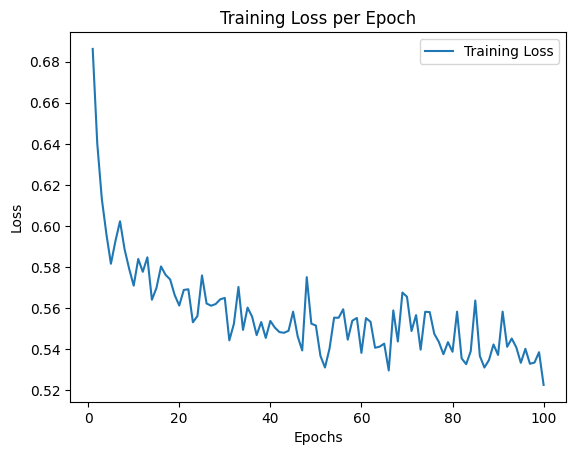

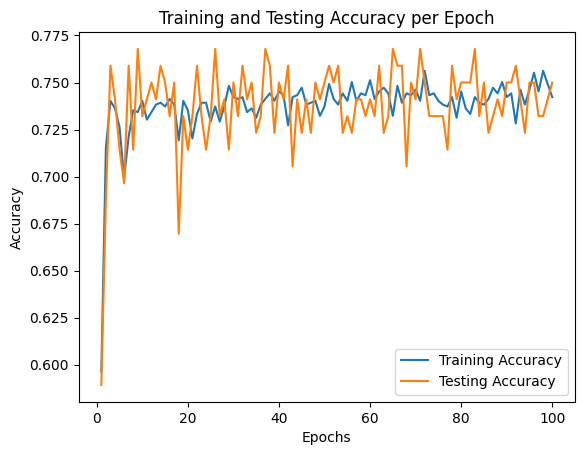

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(train_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss per Epoch')
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracy per Epoch')
    plt.show()

# Training loop
train_losses = []
train_accuracies = []
test_accuracies = []

epochs = 100
for epoch in range(epochs):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot graphs
plot_graphs(train_losses, train_accuracies, test_accuracies)


## GAE Implementation of Protein 

In [ ]:
def train(model, loss_fcn, optimizer, train_dataloader, val_dataloader, num_epochs):
    model = model.double()
    model.train()

    for epoch in range(num_epochs):
        losses = []
        for batch, batched_graph in enumerate(train_dataloader):
            batched_graph, labels = batched_graph
            logits = model(batched_graph, batched_graph.ndata['node_attr'].double())
            loss = loss_fcn(logits, labels.T[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.mean(losses)

        if epoch % 5 == 0:
            print("Epoch {} | Loss: {:.4f}".format(epoch, loss_data))
            test(model, loss_fcn, val_dataloader)

In [ ]:
def test(model, loss_fcn, dataloader):
    scores = []
    for batch, batched_graph in enumerate(dataloader):
        batched_graph, labels = batched_graph
        scores.append(
            evaluate(model, batched_graph, labels, loss_fcn))
    mean_scores = np.mean(scores)
    print("Accuracy score: {:.4f}".format(mean_scores))

In [ ]:
def evaluate(model, batched_graph, labels, loss_fcn):
    model = model.double()
    model.eval()
    with torch.no_grad():
        output = model(batched_graph, batched_graph.ndata['node_attr'].double())

    labels = labels.T[0]
    loss = loss_fcn(output, labels)
    predict = output.argmax(dim=1)
    score = (labels == predict).sum().item() / len(labels)

    return score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
from dgl.nn import GraphConv
from sklearn.model_selection import train_test_split
import numpy as np
from dgl.data import TUDataset

# Define GCN layer
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.gcn = GraphConv(in_feats, out_feats)

    def forward(self, g, h):
        return self.gcn(g, h)

# Build the GAE encoder model
class Encoder(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Encoder, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_feats)
        self.gcn2 = GCNLayer(hidden_feats, out_feats)
        self.relu = nn.ReLU()

    def forward(self, g, h):
        h = self.gcn1(g, h)
        h = self.relu(h)
        h = self.gcn2(g, h)
        return h

# Build the GAE decoder model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

    def forward(self, z):
        z_transpose = z.t()
        adj_pred = torch.sigmoid(torch.matmul(z, z_transpose))
        return adj_pred

# Define the training and evaluation functions
# Define the training and evaluation functions
def train(encoder, decoder, g, features, adj_orig, optimizer, criterion):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()

    z = encoder(g, features)
    adj_pred = decoder(z)

    loss = criterion(adj_pred, adj_orig)
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(encoder, decoder, g, features, adj_orig, criterion):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        z = encoder(g, features)
        adj_pred = decoder(z)
        loss = criterion(adj_pred, adj_orig)

    return loss.item()

# Prepare the dataset and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_proteins = TUDataset(name='PROTEINS')
dataset_proteins.graph_lists = [dgl.add_self_loop(graph) for graph in dataset_proteins.graph_lists]

# Set parameters
graph, _ = dataset_proteins[0]
num_node_features = graph.ndata['node_attr'].shape[1]
in_feats = num_node_features
hidden_feats = 64
out_feats = 32
lr = 0.01
epochs = 100


# Prepare the dataset
train_dataset, test_dataset = train_test_split(dataset_proteins.graph_lists, test_size=0.1, random_state=42)
train_graphs = [graph.to(device) for graph in train_dataset]
test_graphs = [graph.to(device) for graph in test_dataset]

# Initialize the models and optimizer
encoder = Encoder(in_feats, hidden_feats, out_feats).to(device)
decoder = Decoder().to(device)
model = nn.Sequential(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# Train and evaluate the GAE
for epoch in range(epochs):
    train_losses = []
    for g in train_graphs:
        features = g.ndata['node_attr'].float().to(device)
        adj_orig = torch.Tensor(g.adjacency_matrix().to_dense()).to(device)
        train_loss = train(encoder, decoder, g, features, adj_orig, optimizer, criterion)
        train_losses.append(train_loss)

    train_loss_mean = np.mean(train_losses)

    test_losses = []
    for g in test_graphs:
        features = g.ndata['node_attr'].float().to(device)
        adj_orig = torch.Tensor(g.adjacency_matrix().to_dense()).to(device)
        test_loss = evaluate(encoder, decoder, g, features, adj_orig, criterion)
        test_losses.append(test_loss)

    test_loss_mean = np.mean(test_losses)

    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss_mean:.4f}, Test Loss: {test_loss_mean:.4f}')


Epoch: 1, Train Loss: 0.7906, Test Loss: 0.7596
Epoch: 2, Train Loss: 0.7302, Test Loss: 0.7337
Epoch: 3, Train Loss: 0.7474, Test Loss: 0.7289
Epoch: 4, Train Loss: 0.7353, Test Loss: 0.7437
Epoch: 5, Train Loss: 0.7246, Test Loss: 0.7656
Epoch: 6, Train Loss: 0.7494, Test Loss: 0.7335
Epoch: 7, Train Loss: 0.7349, Test Loss: 0.7270
Epoch: 8, Train Loss: 0.7084, Test Loss: 0.7264
Epoch: 9, Train Loss: 0.7103, Test Loss: 0.7273
Epoch: 10, Train Loss: 0.7105, Test Loss: 0.7288
Epoch: 11, Train Loss: 0.7085, Test Loss: 0.7375
Epoch: 12, Train Loss: 0.7048, Test Loss: 0.7695
Epoch: 13, Train Loss: 0.7046, Test Loss: 0.8531
Epoch: 14, Train Loss: 0.7150, Test Loss: 0.9180
Epoch: 15, Train Loss: 0.7085, Test Loss: 0.9153
Epoch: 16, Train Loss: 0.7092, Test Loss: 0.8933
Epoch: 17, Train Loss: 0.7085, Test Loss: 0.8942
Epoch: 18, Train Loss: 0.7085, Test Loss: 0.8869
Epoch: 19, Train Loss: 0.7081, Test Loss: 0.9018
Epoch: 20, Train Loss: 0.7085, Test Loss: 0.8500
Epoch: 21, Train Loss: 0.7066